In [27]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [29]:
fake = pd.read_csv('/content/drive/MyDrive/Fake_news_detection/fake.csv')
true = pd.read_csv('/content/drive/MyDrive/Fake_news_detection/true.csv')

print("Fake shape:", fake.shape)
print("True shape:", true.shape)


Fake shape: (23481, 4)
True shape: (21417, 4)


In [30]:

fake['label'] = 'fake'
true['label'] = 'true'

data = pd.concat([fake, true], axis=0).reset_index(drop=True)
data = data.sample(frac=1).reset_index(drop=True)
data.head()


,title,text,subject,date,label
0,"Senate slaps new sanctions on Russia, putting ...",WASHINGTON (Reuters) - The U.S. Senate voted a...,politicsNews,"July 27, 2017",true
1,Icelandic voters give center-left opposition n...,(Reuters) - Icelanders voted in favor of a lef...,worldnews,"October 29, 2017",true
2,Courts Decide Conspiracy Nut Alex Jones Is To...,Alex Jones of the conspiracy theory website In...,News,"April 28, 2017",fake
3,Jeb Bush BLASTS Steve King’s Anti-Immigrant R...,Representative Steve King ( R-Iowa) is a notor...,News,"March 13, 2017",fake
4,Puerto Rico either gets legislative fix or hum...,NEW YORK (Reuters) - Puerto Rico’s debt crisis...,politicsNews,"May 12, 2016",true


In [31]:
data.to_csv('/content/drive/MyDrive/Fake_news_detection/merged_fake_true_news.csv', index=False)


In [32]:
merged_fake_true_news = pd.read_csv('/content/drive/MyDrive/Fake_news_detection/merged_fake_true_news.csv')

print("merged_fake_true_news shape:", merged_fake_true_news.shape)


merged_fake_true_news shape: (44898, 5)


In [33]:
data['label'].value_counts(normalize=True) * 100

,proportion
label,
fake,52.298543
true,47.701457


In [34]:
df = pd.read_csv("/content/drive/MyDrive/Fake_news_detection/merged_fake_true_news.csv")
df.drop_duplicates(subset=['text'], inplace=True)
df.dropna(subset=['text'], inplace=True)
df = df[df['text'].str.len() > 20]
df = df[~df['text'].str.match(r'^[0-9\W]+$', na=False)]
df = df[~df['text'].str.contains(r'^http', na=False)]
df = df[~df['text'].str.contains("subscribe|click here|read more|follow us", case=False)]

def clean_basic(text):
    text = re.sub(r"http\S+|www.\S+", " ", text)
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df["clean_text"] = df["text"].apply(clean_basic)
df.reset_index(drop=True, inplace=True)
df.head()


,title,text,subject,date,label,clean_text
0,"Senate slaps new sanctions on Russia, putting ...",WASHINGTON (Reuters) - The U.S. Senate voted a...,politicsNews,"July 27, 2017",true,WASHINGTON (Reuters) - The U.S. Senate voted a...
1,Icelandic voters give center-left opposition n...,(Reuters) - Icelanders voted in favor of a lef...,worldnews,"October 29, 2017",true,(Reuters) - Icelanders voted in favor of a lef...
2,Courts Decide Conspiracy Nut Alex Jones Is To...,Alex Jones of the conspiracy theory website In...,News,"April 28, 2017",fake,Alex Jones of the conspiracy theory website In...
3,Jeb Bush BLASTS Steve King’s Anti-Immigrant R...,Representative Steve King ( R-Iowa) is a notor...,News,"March 13, 2017",fake,Representative Steve King ( R-Iowa) is a notor...
4,Puerto Rico either gets legislative fix or hum...,NEW YORK (Reuters) - Puerto Rico’s debt crisis...,politicsNews,"May 12, 2016",true,NEW YORK (Reuters) - Puerto Rico’s debt crisis...


In [35]:
df.shape


(36608, 6)

In [36]:
df.to_csv("/content/drive/MyDrive/Fake_news_detection/clean_dataset.csv", index=False)


In [37]:
df['label'].value_counts(normalize=True) * 100


,proportion
label,
true,57.725087
fake,42.274913


In [38]:
df["clean_text_lower"] = df["clean_text"].str.lower()
df[["clean_text", "clean_text_lower"]].head()


,clean_text,clean_text_lower
0,WASHINGTON (Reuters) - The U.S. Senate voted a...,washington (reuters) - the u.s. senate voted a...
1,(Reuters) - Icelanders voted in favor of a lef...,(reuters) - icelanders voted in favor of a lef...
2,Alex Jones of the conspiracy theory website In...,alex jones of the conspiracy theory website in...
3,Representative Steve King ( R-Iowa) is a notor...,representative steve king ( r-iowa) is a notor...
4,NEW YORK (Reuters) - Puerto Rico’s debt crisis...,new york (reuters) - puerto rico’s debt crisis...


In [39]:
punct_mapping = str.maketrans("", "", string.punctuation)
df["clean_text_no_punct"] = df["clean_text_lower"].apply(lambda x: x.translate(punct_mapping))
df["clean_text_no_punct"] = df["clean_text_no_punct"].str.strip()
df[["clean_text_lower", "clean_text_no_punct"]].head()

,clean_text_lower,clean_text_no_punct
0,washington (reuters) - the u.s. senate voted a...,washington reuters the us senate voted almost...
1,(reuters) - icelanders voted in favor of a lef...,reuters icelanders voted in favor of a leftle...
2,alex jones of the conspiracy theory website in...,alex jones of the conspiracy theory website in...
3,representative steve king ( r-iowa) is a notor...,representative steve king riowa is a notoriou...
4,new york (reuters) - puerto rico’s debt crisis...,new york reuters puerto rico’s debt crisis if...


In [40]:
df["tokens"] = df["clean_text_no_punct"].apply(lambda x: x.split())
df[["clean_text_no_punct", "tokens"]].head()



,clean_text_no_punct,tokens
0,washington reuters the us senate voted almost...,"[washington, reuters, the, us, senate, voted, ..."
1,reuters icelanders voted in favor of a leftle...,"[reuters, icelanders, voted, in, favor, of, a,..."
2,alex jones of the conspiracy theory website in...,"[alex, jones, of, the, conspiracy, theory, web..."
3,representative steve king riowa is a notoriou...,"[representative, steve, king, riowa, is, a, no..."
4,new york reuters puerto rico’s debt crisis if...,"[new, york, reuters, puerto, rico’s, debt, cri..."


In [41]:
stop_words = set(stopwords.words("english"))
df["tokens_no_stopwords"] = df["tokens"].apply(
    lambda words: [word for word in words if word not in stop_words]
)
df[["tokens", "tokens_no_stopwords"]].head()

,tokens,tokens_no_stopwords
0,"[washington, reuters, the, us, senate, voted, ...","[washington, reuters, us, senate, voted, almos..."
1,"[reuters, icelanders, voted, in, favor, of, a,...","[reuters, icelanders, voted, favor, leftleanin..."
2,"[alex, jones, of, the, conspiracy, theory, web...","[alex, jones, conspiracy, theory, website, inf..."
3,"[representative, steve, king, riowa, is, a, no...","[representative, steve, king, riowa, notorious..."
4,"[new, york, reuters, puerto, rico’s, debt, cri...","[new, york, reuters, puerto, rico’s, debt, cri..."


In [42]:
ps = PorterStemmer()
df["stemmed_tokens"] = df["tokens_no_stopwords"].apply(lambda tokens: [ps.stem(word) for word in tokens])
df[["tokens_no_stopwords", "stemmed_tokens"]].head()


,tokens_no_stopwords,stemmed_tokens
0,"[washington, reuters, us, senate, voted, almos...","[washington, reuter, us, senat, vote, almost, ..."
1,"[reuters, icelanders, voted, favor, leftleanin...","[reuter, iceland, vote, favor, leftlean, fourp..."
2,"[alex, jones, conspiracy, theory, website, inf...","[alex, jone, conspiraci, theori, websit, infow..."
3,"[representative, steve, king, riowa, notorious...","[repres, steve, king, riowa, notori, racist, s..."
4,"[new, york, reuters, puerto, rico’s, debt, cri...","[new, york, reuter, puerto, rico’, debt, crisi..."


In [43]:
lemmatizer = WordNetLemmatizer()
df["lemmatized_tokens"] = df["stemmed_tokens"].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
df[["stemmed_tokens", "lemmatized_tokens"]].head()


,stemmed_tokens,lemmatized_tokens
0,"[washington, reuter, us, senat, vote, almost, ...","[washington, reuter, u, senat, vote, almost, u..."
1,"[reuter, iceland, vote, favor, leftlean, fourp...","[reuter, iceland, vote, favor, leftlean, fourp..."
2,"[alex, jone, conspiraci, theori, websit, infow...","[alex, jone, conspiraci, theori, websit, infow..."
3,"[repres, steve, king, riowa, notori, racist, s...","[repres, steve, king, riowa, notori, racist, s..."
4,"[new, york, reuter, puerto, rico’, debt, crisi...","[new, york, reuter, puerto, rico’, debt, crisi..."


In [44]:
df["final_text"] = df["lemmatized_tokens"].apply(lambda x: " ".join(x))
df[["lemmatized_tokens", "final_text"]].head()


,lemmatized_tokens,final_text
0,"[washington, reuter, u, senat, vote, almost, u...",washington reuter u senat vote almost unanim t...
1,"[reuter, iceland, vote, favor, leftlean, fourp...",reuter iceland vote favor leftlean fourparti c...
2,"[alex, jone, conspiraci, theori, websit, infow...",alex jone conspiraci theori websit infowar mad...
3,"[repres, steve, king, riowa, notori, racist, s...",repres steve king riowa notori racist sunday c...
4,"[new, york, reuter, puerto, rico’, debt, crisi...",new york reuter puerto rico’ debt crisi left u...


In [45]:
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2)
)
X_tfidf = tfidf.fit_transform(df["final_text"])
print(X_tfidf.shape)



(36608, 10000)


In [46]:
X = X_tfidf
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(X_train.shape, X_test.shape)



(25625, 10000) (10983, 10000)


In [47]:
model = MultinomialNB()
model.fit(X_train, y_train)



MultinomialNB()

In [48]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.9582081398524993
              precision    recall  f1-score   support

        fake       0.95      0.95      0.95      4643
        true       0.96      0.97      0.96      6340

    accuracy                           0.96     10983
   macro avg       0.96      0.96      0.96     10983
weighted avg       0.96      0.96      0.96     10983



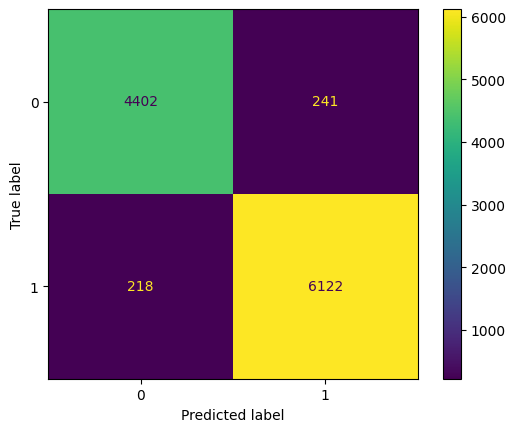

In [49]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [ ]:
def min_edit_distance(s1, s2):
    m = len(s1)
    n = len(s2)
    dp = [[0 for _ in range(n+1)] for _ in range(m+1)]
    for i in range(m+1):
        dp[i][0] = i
    for j in range(n+1):
        dp[0][j] = j
    for i in range(1, m+1):
        for j in range(1, n+1):
            if s1[i-1] == s2[j-1]:
                cost = 0
            else:
                cost = 1
            dp[i][j] = min(
                dp[i-1][j] + 1,
                dp[i][j-1] + 1,
                dp[i-1][j-1] + cost
            )
    return dp[m][n]

text1 = input("Enter first text: ")
text2 = input("Enter second text: ")
distance = min_edit_distance(text1, text2)
similarity = 1 - (distance / max(len(text1), len(text2)))

print("Minimum Edit Distance:", distance)
print("Similarity:", round(similarity, 4))
